# **Online Retail Transactions**

--> Analyser les transactions e-commerce en fonction du temps pour identifier des comportements temporels anormaux (heures, jours ou volumes inhabituels).

--> Questions cles:


*   Quelles sont les heures et jours normaux d’achat ?

* Existe-t-il des périodes d’activité anormales ?

* Peut-on détecter des pics isolés ou des creux inhabituels ?
*   Élément de liste



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# **Data Cleaning**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_excel('/content/drive/MyDrive/projet_libre/Anomaly detection in time series/customer.xlsx')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.shape

(541909, 8)

In [7]:
#Check for missing or null values in the dataset
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


In [8]:
# fill it by the mean value of corresponding columns for numeric_columns
df.fillna(df.mean(numeric_only=True), inplace=True)

In [9]:
# fill it by uknown for categorical_columns
df['Description'] = df['Description'].fillna('Unknown')

In [10]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


- **errors='coerce'** transforme les dates invalides en NaT (valeurs manquantes).

In [11]:
# delete missing dates
df= df.dropna(subset=['InvoiceDate'])

In [12]:
# delete duplicate dates
df.duplicated().sum()

np.int64(5268)

In [13]:
df = df.drop_duplicates()

In [14]:
# sort values
df = df.sort_values(by='InvoiceDate').reset_index(drop=True)

# **Features engineering**

In [15]:
# creat variables
df['hour'] = df['InvoiceDate'].dt.hour
df['day_of_week'] = df['InvoiceDate'].dt.dayofweek
df['month'] = df['InvoiceDate'].dt.month
df['day_name'] = df['InvoiceDate'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['date'] = df['InvoiceDate'].dt.date

--> pour colonne **is_weekend**:

1 = week-end

0 = jour ouvré

In [16]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,hour,day_of_week,month,day_name,is_weekend,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,8,2,12,Wednesday,0,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,Wednesday,0,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,8,2,12,Wednesday,0,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,Wednesday,0,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,8,2,12,Wednesday,0,2010-12-01


# **EDA (Exploratory Data Analysis)**

--> EDA explore les donnees avant de modeliser afin de comprendre la structe des donnees, leur qualite,les premiers patterns

--> il va repond aussi a ces questions:
* Quelles sont les heures normales d’achat ?

* Quels jours sont les plus actifs ?

* Existe-t-il une saisonnalité ?

- `Activité par heure`

In [17]:
trans_per_hour = df.groupby('hour').size().reset_index(name='trans_per_hour')
trans_per_hour

,hour,trans_per_hour
0,6,41
1,7,383
2,8,8906
3,9,34314
4,10,48808
5,11,56949
6,12,77573
7,13,71247
8,14,66572
9,15,76938


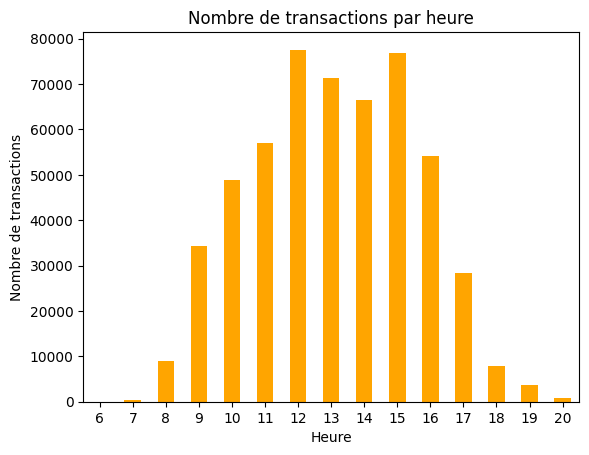

In [18]:
trans_per_hour.plot(kind='bar', x='hour', y='trans_per_hour', color='orange', legend=False)

plt.title("Nombre de transactions par heure")
plt.xlabel("Heure")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=0)
plt.show()

--> **Resume:**

- C'est une journée caractérisée par une forte activité centrale (de 11h à 16h) avec deux moments forts à 12h et 15h, encadrée par une montée et une descente rapides en début et fin de journée.

- `Activité par jour de la semaine`

In [19]:
trans_per_day = df.groupby('day_name').size().reset_index(name='trans_per_day')
trans_per_day

,day_name,trans_per_day
0,Friday,81565
1,Monday,94435
2,Sunday,62806
3,Thursday,103056
4,Tuesday,101064
5,Wednesday,93715


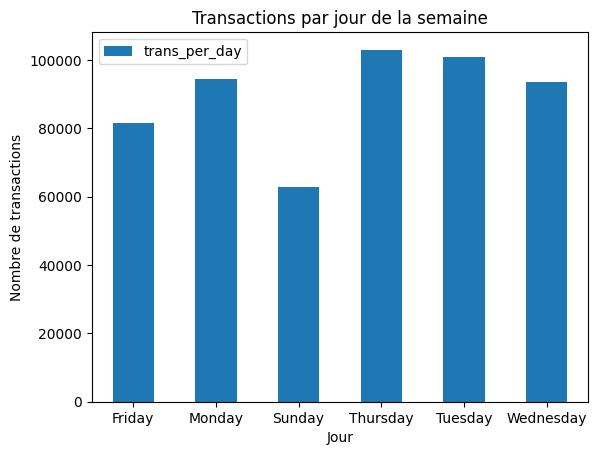

In [20]:
trans_per_day.plot(kind='bar', x='day_name', y='trans_per_day')
plt.title("Transactions par jour de la semaine")
plt.xlabel("Jour")
plt.ylabel("Nombre de transactions")
plt.xticks(rotation=0)
plt.show()

--> **Resume:**

- L’analyse par jour de la semaine montre une absence totale d’activité le samedi. Ce comportement suggère que l’entreprise opère exclusivement sur des jours ouvrés, ce qui est cohérent avec un modèle B2B

- Le dimanche peut exister (commandes enregistrées tardivement ou automatiquement)

-  `Activité journalière`

In [27]:
df_per_date = df.groupby('date').size().reset_index(name='trans_per_date')

df_per_date

,date,trans_per_date
0,2010-12-01,3064
1,2010-12-02,2068
2,2010-12-03,2185
3,2010-12-05,2620
4,2010-12-06,3830
...,...,...
300,2011-12-05,5292
301,2011-12-06,3313
302,2011-12-07,2406
303,2011-12-08,4907


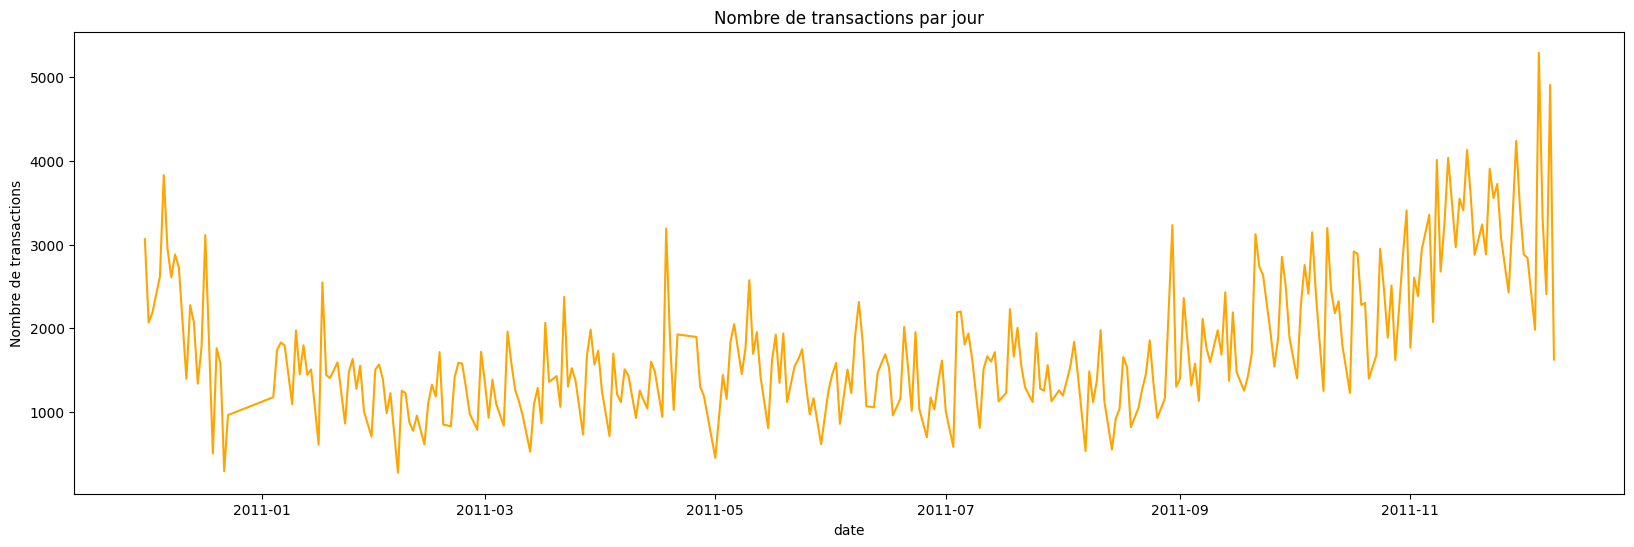

In [28]:
df_per_date.set_index('date')['trans_per_date'].plot(figsize=(20, 6), color='orange')

plt.title("Nombre de transactions par jour")
plt.ylabel("Nombre de transactions")
plt.show()

**--> Observation:**

- L’analyse exploratoire temporelle montre que l’activité est fortement concentrée entre certaines heures de la journée, avec une baisse significative pendant la nuit. De plus, les jours ouvrés présentent un volume de transactions plus élevé que les week-ends, indiquant un comportement d’achat principalement professionnel.

In [29]:
FEATURE = 'trans_per_date'

#  **Détection d’anomalies (méthode statistique)**

# **Robust z-score**

In [30]:
median = df_per_date[FEATURE].median()
mad = np.median(np.abs(df_per_date[FEATURE] - median))

df_per_date['robust_z'] = 0.6745 * (df_per_date[FEATURE] - median) / mad
rz_scores = np.abs(df_per_date['robust_z'])


In [31]:
# Seuil classique du Robust Z-score
rz_threshold = 3.5

# Initialisation : normal = 1
df_per_date['anomaly_rz'] = 1

# Marquer anomalies = -1
df_per_date.loc[
    df_per_date['robust_z'].abs() > rz_threshold,
    'anomaly_rz'
] = -1
df_per_date.head()

,date,trans_per_date,robust_z,anomaly_rz
0,2010-12-01,3064,2.466038,1
1,2010-12-02,2068,0.827496,1
2,2010-12-03,2185,1.019976,1
3,2010-12-05,2620,1.735604,1
4,2010-12-06,3830,3.726201,-1


**`Visualisation`**

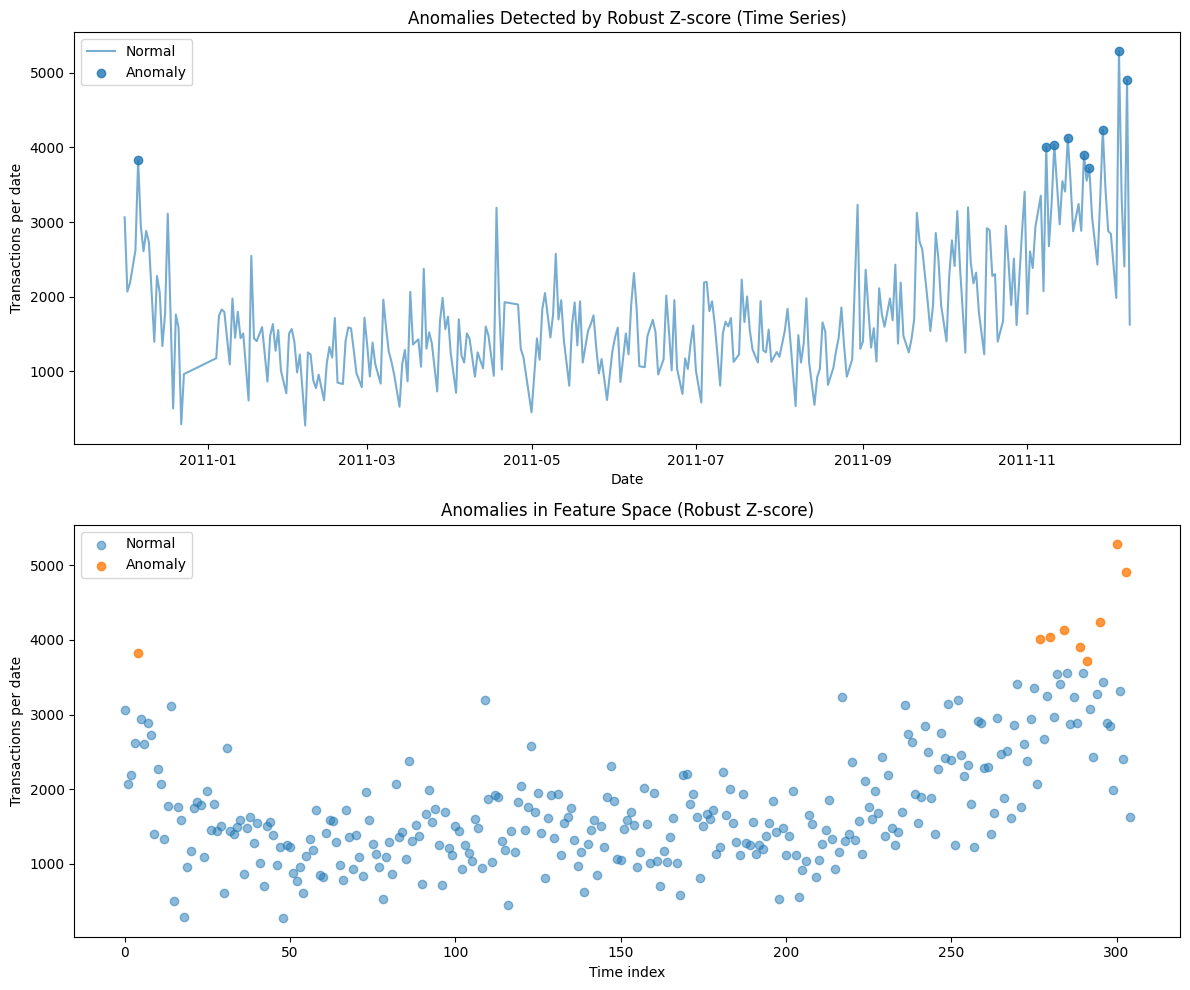

In [32]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# =========================
# 1️⃣ Time series plot
# =========================
ax1.plot(
    df_per_date['date'],
    df_per_date['trans_per_date'],
    label='Normal',
    alpha=0.6
)

ax1.scatter(
    df_per_date['date'][df_per_date['anomaly_rz'] == -1],
    df_per_date['trans_per_date'][df_per_date['anomaly_rz'] == -1],
    label='Anomaly',
    alpha=0.8
)

ax1.set_title('Anomalies Detected by Robust Z-score (Time Series)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transactions per date')
ax1.legend()

# =========================
# 2️⃣ Scatter plot (feature space)
# =========================
ax2.scatter(
    df_per_date.index[df_per_date['anomaly_rz'] == 1],
    df_per_date['trans_per_date'][df_per_date['anomaly_rz'] == 1],
    label='Normal',
    alpha=0.5
)

ax2.scatter(
    df_per_date.index[df_per_date['anomaly_rz'] == -1],
    df_per_date['trans_per_date'][df_per_date['anomaly_rz'] == -1],
    label='Anomaly',
    alpha=0.8
)

ax2.set_xlabel('Time index')
ax2.set_ylabel('Transactions per date')
ax2.set_title('Anomalies in Feature Space (Robust Z-score)')
ax2.legend()

plt.tight_layout()
plt.show()


**--> Courbe 1 : Série temporelle**
- Quand les anomalies apparaissent-elles dans le temps ?

📌 Tu vois :

- pics

- ruptures

- événements inhabituels

**--> Courbe 2 : Espace des features**
- À quel point ces valeurs sont-elles extrêmes par rapport aux autres ?

✔️ Utile pour :

- comprendre la séparation normal / anomalie

- vérifier si le seuil est cohérent


**`Statistiques sur les anomalies détectées`**

In [33]:
total_points = len(df_per_date)
anomaly_count = (df_per_date['anomaly_rz'] == -1).sum()
anomaly_percentage = (anomaly_count / total_points) * 100

print(f"Total number of days analyzed: {total_points}")
print(f"Number of anomalous days detected (Robust Z-score): {anomaly_count}")
print(f"Percentage of anomalous days: {anomaly_percentage:.2f}%")

Total number of days analyzed: 305
Number of anomalous days detected (Robust Z-score): 9
Percentage of anomalous days: 2.95%


**`Top 5 des anomalies les plus importantes`**

In [34]:
print("\nTop 5 transaction-count anomalies (Robust Z-score):")

top_anomalies_rz = (
    df_per_date[df_per_date['anomaly_rz'] == -1]
    .nlargest(5, 'trans_per_date')
)

for _, row in top_anomalies_rz.iterrows():
    print(f"Date: {row['date']}, Transactions: {row['trans_per_date']}")


Top 5 transaction-count anomalies (Robust Z-score):
Date: 2011-12-05, Transactions: 5292
Date: 2011-12-08, Transactions: 4907
Date: 2011-11-29, Transactions: 4238
Date: 2011-11-16, Transactions: 4130
Date: 2011-11-11, Transactions: 4036


# **Isolation Forest**

In [36]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Normalisation (recommandée)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_per_date[[FEATURE]])

# Isolation Forest
if_model = IsolationForest(
    n_estimators=100, #Nombre d’arbres dans la forêt
    contamination=0.05,
    random_state=42
)

df_per_date['anomaly_if'] = if_model.fit_predict(X_scaled)
df_per_date['if_score'] = if_model.decision_function(X_scaled)
if_scores = df_per_date['if_score']

**`Visualisation`**

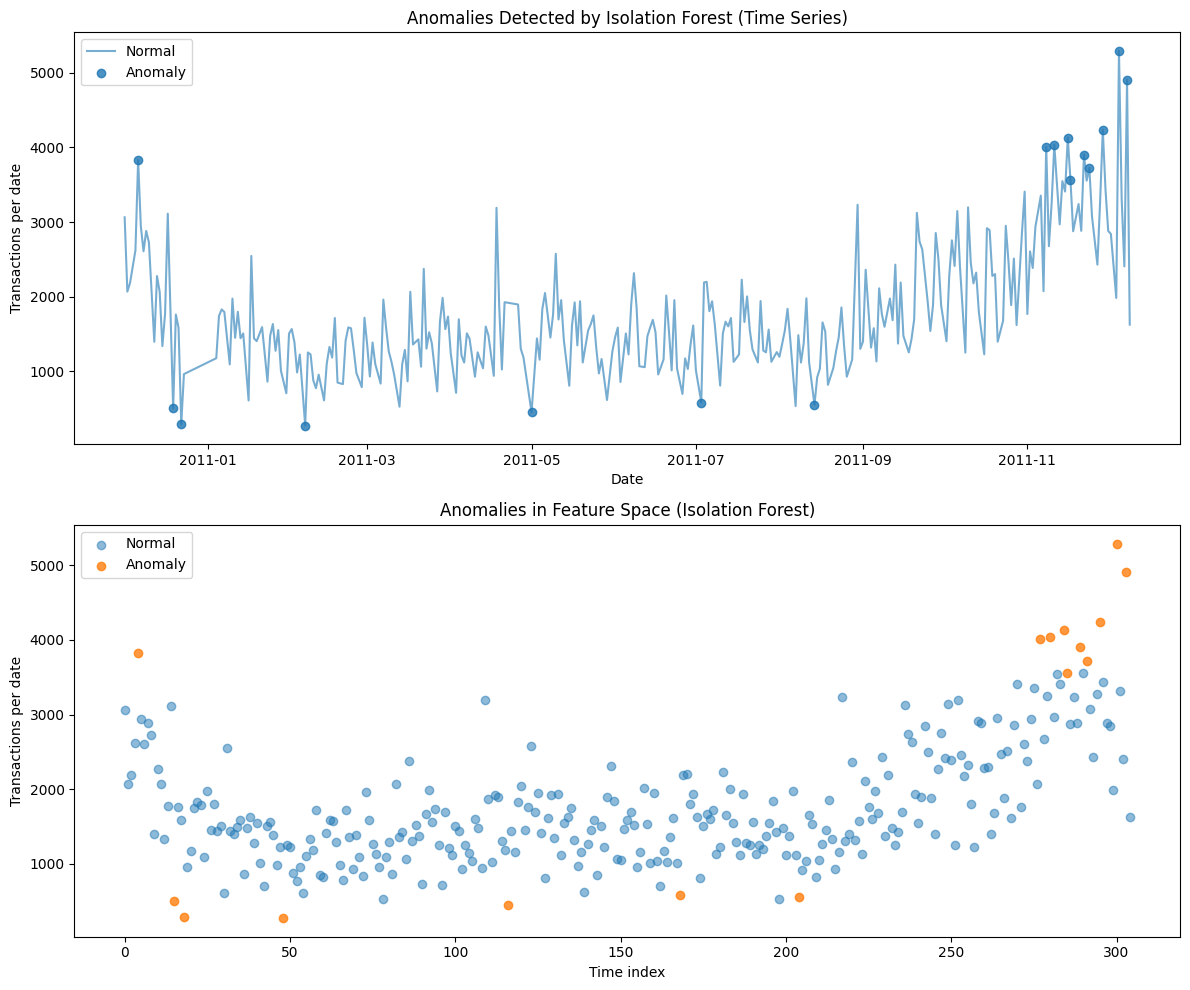

In [37]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# =========================
#  Time series plot
# =========================
ax1.plot(
    df_per_date['date'],
    df_per_date['trans_per_date'],
    label='Normal',
    alpha=0.6
)

ax1.scatter(
    df_per_date['date'][df_per_date['anomaly_if'] == -1],
    df_per_date['trans_per_date'][df_per_date['anomaly_if'] == -1],
    label='Anomaly',
    alpha=0.8
)

ax1.set_title('Anomalies Detected by Isolation Forest (Time Series)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transactions per date')
ax1.legend()

# =========================
#  Scatter plot (feature space)
# =========================
ax2.scatter(
    df_per_date.index[df_per_date['anomaly_if'] == 1],
    df_per_date['trans_per_date'][df_per_date['anomaly_if'] == 1],
    label='Normal',
    alpha=0.5
)

ax2.scatter(
    df_per_date.index[df_per_date['anomaly_if'] == -1],
    df_per_date['trans_per_date'][df_per_date['anomaly_if'] == -1],
    label='Anomaly',
    alpha=0.8
)

ax2.set_xlabel('Time index')
ax2.set_ylabel('Transactions per date')
ax2.set_title('Anomalies in Feature Space (Isolation Forest)')
ax2.legend()

plt.tight_layout()
plt.show()


**`Statistiques sur les anomalies détectées`**

In [38]:
# Total points
total_points = len(df_per_date)

# Nombre d'anomalies
anomaly_count = (df_per_date['anomaly_if'] == -1).sum()

# Pourcentage
anomaly_percentage = (anomaly_count / total_points) * 100

print(f"Total number of days analyzed: {total_points}")
print(f"Number of anomalous days detected (ISOLATION FOREST): {anomaly_count}")
print(f"Percentage of anomalous days: {anomaly_percentage:.2f}%")



Total number of days analyzed: 305
Number of anomalous days detected (ISOLATION FOREST): 16
Percentage of anomalous days: 5.25%


**`Top 5 des anomalies les plus importantes`**

In [39]:
print("\nTop 5 highest transaction-count anomalies:")

top_anomalies = (
    df_per_date[df_per_date['anomaly_if'] == -1]
    .nlargest(5, 'trans_per_date')
)

for _, row in top_anomalies.iterrows():
    print(f"Date: {row['date']}, Transactions: {row['trans_per_date']}")



Top 5 highest transaction-count anomalies:
Date: 2011-12-05, Transactions: 5292
Date: 2011-12-08, Transactions: 4907
Date: 2011-11-29, Transactions: 4238
Date: 2011-11-16, Transactions: 4130
Date: 2011-11-11, Transactions: 4036


# **LOF: Local Outlier Factor**

In [40]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

# Normalisation (recommandée)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_per_date[[FEATURE]])

# LOF
lof_model = LocalOutlierFactor(
    n_neighbors=20,      # nombre de voisins
    contamination=0.05
)

df_per_date['anomaly_lof'] = lof_model.fit_predict(X_scaled)
df_per_date['lof_score'] = -lof_model.negative_outlier_factor_
lof_scores = df_per_date['lof_score']
df_per_date.head()

,date,trans_per_date,robust_z,anomaly_rz,if_score,anomaly_if,anomaly_lof,lof_score
0,2010-12-01,3064,2.466038,1,0.042146,1,1,0.994361
1,2010-12-02,2068,0.827496,1,0.103452,1,1,1.237561
2,2010-12-03,2185,1.019976,1,0.095803,1,1,1.126876
3,2010-12-05,2620,1.735604,1,0.073861,1,1,1.045674
4,2010-12-06,3830,3.726201,-1,-0.038684,-1,-1,1.468962


**`Visualisation`**

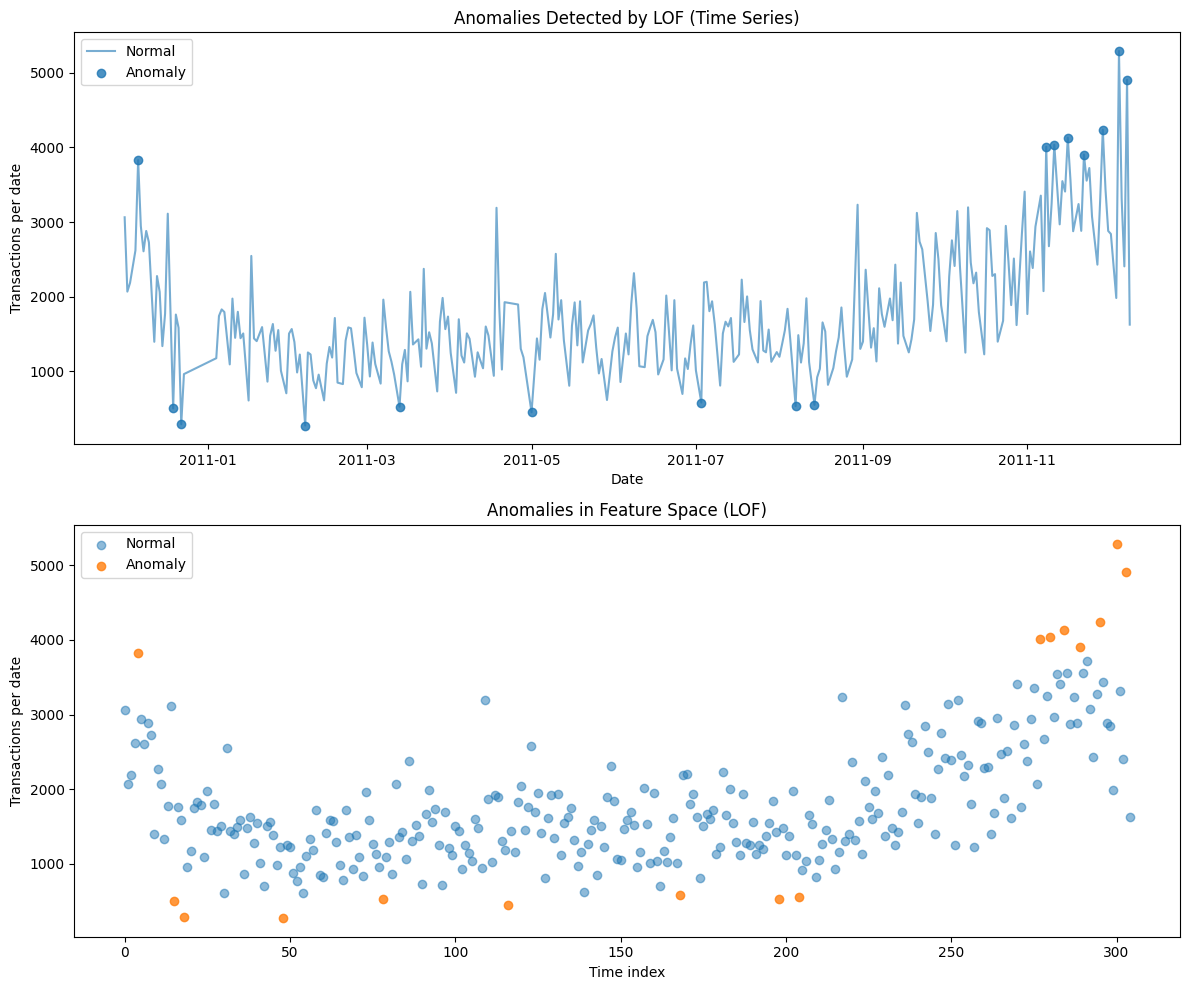

In [41]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# =========================
# 1️⃣ Time series plot (LOF)
# =========================
ax1.plot(
    df_per_date['date'],
    df_per_date['trans_per_date'],
    label='Normal',
    alpha=0.6
)

ax1.scatter(
    df_per_date['date'][df_per_date['anomaly_lof'] == -1],
    df_per_date['trans_per_date'][df_per_date['anomaly_lof'] == -1],
    label='Anomaly',
    alpha=0.8
)

ax1.set_title('Anomalies Detected by LOF (Time Series)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Transactions per date')
ax1.legend()

# =========================
# 2️⃣ Scatter plot (feature space)
# =========================
ax2.scatter(
    df_per_date.index[df_per_date['anomaly_lof'] == 1],
    df_per_date['trans_per_date'][df_per_date['anomaly_lof'] == 1],
    label='Normal',
    alpha=0.5
)

ax2.scatter(
    df_per_date.index[df_per_date['anomaly_lof'] == -1],
    df_per_date['trans_per_date'][df_per_date['anomaly_lof'] == -1],
    label='Anomaly',
    alpha=0.8
)

ax2.set_xlabel('Time index')
ax2.set_ylabel('Transactions per date')
ax2.set_title('Anomalies in Feature Space (LOF)')
ax2.legend()

plt.tight_layout()
plt.show()


In [42]:
total_points = len(df_per_date)
anomaly_count = (df_per_date['anomaly_lof'] == -1).sum()
anomaly_percentage = (anomaly_count / total_points) * 100

print(f"Total number of days analyzed: {total_points}")
print(f"Number of anomalous days detected (LOF): {anomaly_count}")
print(f"Percentage of anomalous days: {anomaly_percentage:.2f}%")


Total number of days analyzed: 305
Number of anomalous days detected (LOF): 16
Percentage of anomalous days: 5.25%


In [43]:
print("\nTop 5 transaction-count anomalies (LOF):")

top_anomalies_lof = (
    df_per_date[df_per_date['anomaly_lof'] == -1]
    .nlargest(5, 'trans_per_date')
)

for _, row in top_anomalies_lof.iterrows():
    print(f"Date: {row['date']}, Transactions: {row['trans_per_date']}")



Top 5 transaction-count anomalies (LOF):
Date: 2011-12-05, Transactions: 5292
Date: 2011-12-08, Transactions: 4907
Date: 2011-11-29, Transactions: 4238
Date: 2011-11-16, Transactions: 4130
Date: 2011-11-11, Transactions: 4036
